# Main

this notebook is the main file of the project, here the model are trained and evaluated

# Import libraies

In [21]:
#coustom modules
from train import Trainer
from models import Generator, Critic
import data.data_preprocessing as data_prep
import utils
from rescale_generated import Rescale

#pytorch modules
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

#general modules
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os

# Create the dataset

The following function transform the data bere using them as input for the model.

In [16]:
#create the transformer to scale the series
class ScaleInput:
    
    def __init__(self, scale) -> None:
        self.scale = scale

    def __call__(self, sample):
        return sample * self.scale

class Magnitude_Scaler:

    def __init__(self, scale):
        self.scale = scale

    def __call__(self, sample):

        cap = torch.max(sample) * self.scale
        bottom = torch.min(sample) * self.scale

        X_std = (sample - bottom) / (cap - bottom)
        X_scaled = X_std * (cap - bottom) + bottom
        
        return X_scaled

the following code create the dataset and plot some sample of the dataset series

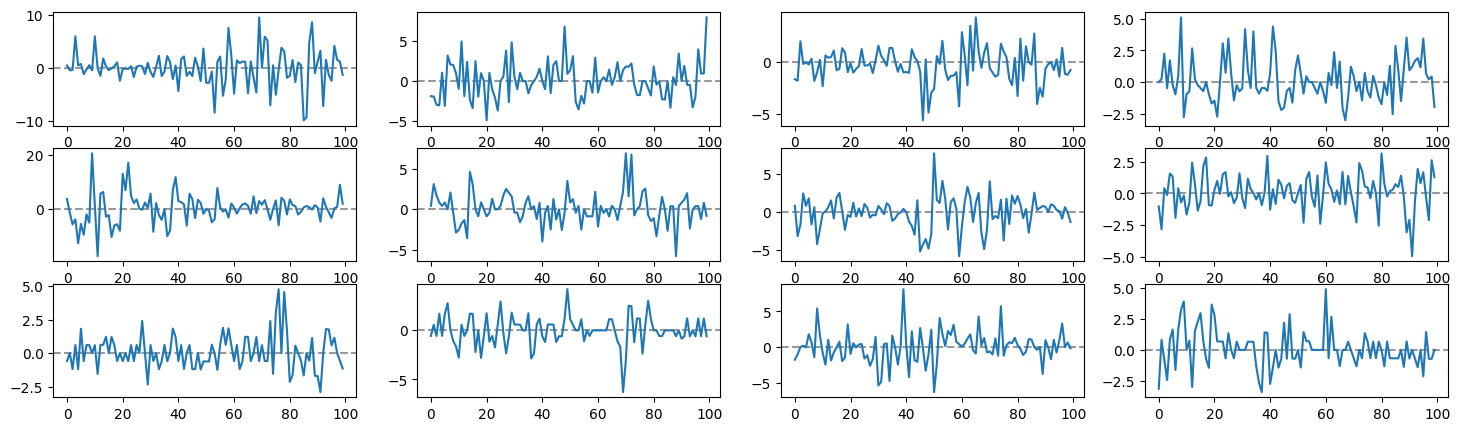

In [23]:
np.random.seed(0)
#initialize the transformer
scaler = ScaleInput(100)
#create the dataset
dataset = data_prep.WindowsDaset(r'data\dataset_100_winds',transform = scaler)
#plot some series
rows = 3
columns = 4
fig, axs = plt.subplots(rows, columns, figsize=(18,5))
for ax, i in zip(axs.ravel(),np.random.randint(0, len(dataset),size=rows * columns)):
    ax.axhline(0, color = 'black', alpha =0.4, ls = '--')
    ax.plot(dataset[i])

# Model initialization and training

the following box of code contains all the hyperparameters for the model training

In [22]:
#chose the Base directiory to save the run
BASE_DIR = r'C:\Users\bolla\Desktop\CUHK_courses\IASP_elisa\runs'

#global variables for the run
GP_WEIGHT = 10
G_NORM_PEN = 5
CRITIC_IT = 5
PRINT_EVERY = 10
CHECKPOINT_FREQ = 10
BATCH_SIZE = 256
LOG_NAME = 'run_1_0'
EPOCHS = 40

run_ARCHIVE = utils.create_dir(BASE_DIR,'000_007')

In [84]:
import importlib
import models
importlib.reload(models)
from models import Generator, Critic

import train
importlib.reload(train)
from train import Trainer

The following is the core of model training:

run the following cell to further train a model

In [87]:
# Instantiate Generator and Critic + initialize weights
from checkpoints import models as models_test
state_dicts = torch.load('checkpoints/epoch_39.pkl', map_location=torch.device('cpu'))

g = models_test.Generator()
g.load_state_dict(state_dicts['g_state_dict'])
g_opt = torch.optim.RMSprop(g.parameters(), lr=0.05)
#adam optimizer beta1 = 0.5 beta2 .99 lr = 0.003
#grater for discriminator the lr


c = models_test.Critic()
c.load_state_dict(state_dicts['d_state_dict'])
c_opt = torch.optim.RMSprop(c.parameters(), lr=0.05)


run the following cell to train a new model

In [ ]:
g = Generator()
#g_opt = torch.optim.Adam(g.parameters(), lr=0.003, betas=[0.5, 0.99])
g_opt = torch.optim.RMSprop(g.parameters(), lr=0.1)

c = Critic()
#c_opt = torch.optim.Adam(c.parameters(), lr=0.009, betas=[0.5, 0.99])
c_opt = torch.optim.RMSprop(c.parameters(), lr=0.05)

In [ ]:
#create the dataloader
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

# Instantiate Trainer
trainer = Trainer(g, c, g_opt, c_opt,GP_WEIGHT,G_NORM_PEN,CRITIC_IT,PRINT_EVERY,CHECKPOINT_FREQ, ARCHIVE_DIR=run_ARCHIVE)
# Train model
print('Training is about to start...')

trainer.train(data_loader, epochs=EPOCHS, plot_training_samples=True, checkpoint=None)

# Evaluate the model

the following code rescale use the model to generate samples of returns and plot the results

In [103]:
import rescale_generated
importlib.reload(rescale_generated)
from rescale_generated import Rescale


<module 'utils' from 'c:\\Users\\bolla\\Desktop\\CUHK_courses\\IASP_elisa\\final\\utils.py'>

In [120]:
import utils
importlib.reload(utils)
import utils

In [69]:
#create a non-transformed dataset to initialize the rescaler
plain_dataset = data_prep.WindowsDaset(r'data\dataset_100_winds')
#initialize the rescaler
rescaler = Rescale(plain_dataset)

~Scaler initialization~
~computing the min and max quantiles~


100%|██████████| 10353/10353 [01:28<00:00, 116.78it/s]


~computing the distance between peaks~


100%|██████████| 10353/10353 [02:37<00:00, 65.78it/s] 


-0.026881138700983936
[-0.0338908]
-0.09627655126237669
-0.09494322776780316
[-0.06511222]


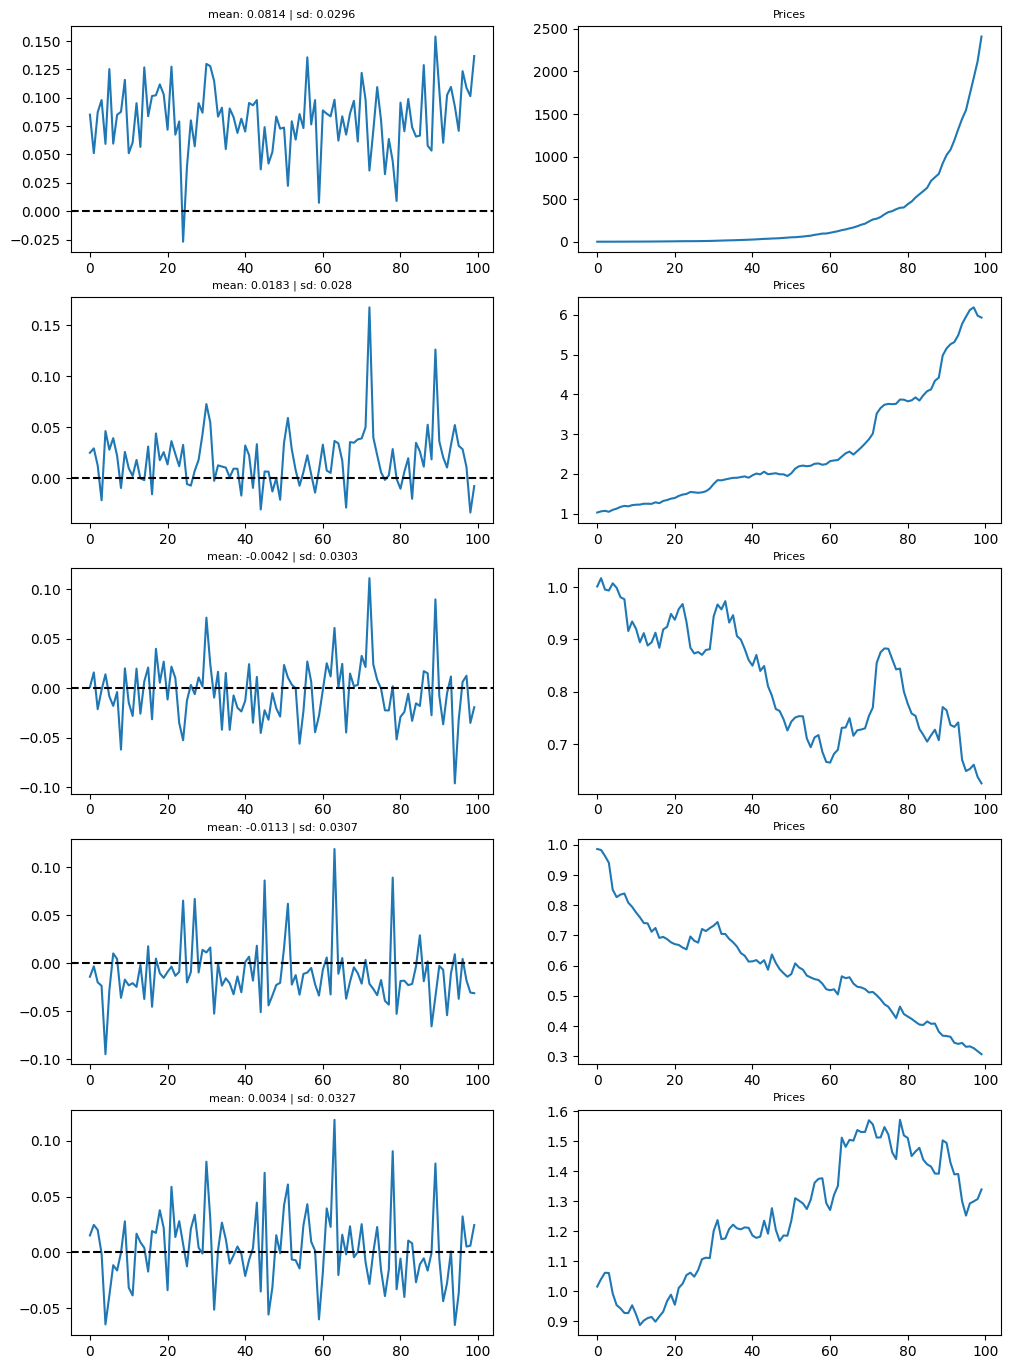

In [123]:
sample = utils.generate_sample(g,5)
scaled = []
#scale the generated series
for i in sample:
    scaled.append(rescaler.scale(i.flatten()))

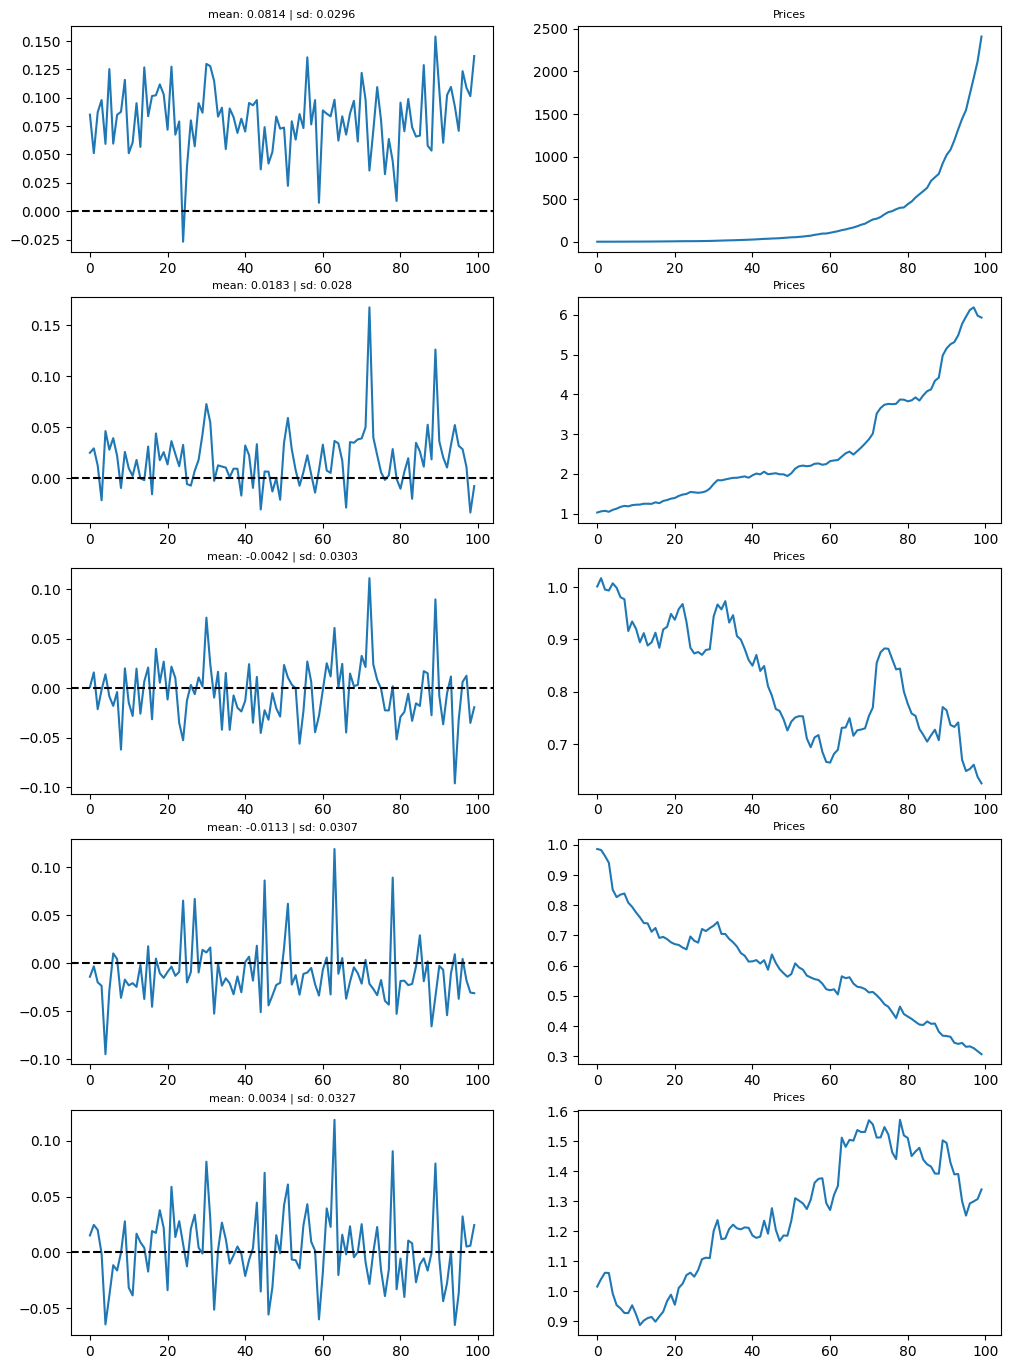

In [125]:
utils.plot_samples_price(scaled)

In [124]:
scaled

[array([ 0.0850301 ,  0.05115764,  0.08713528,  0.0979467 ,  0.05930839,
         0.12522672,  0.05951554,  0.08491775,  0.08756845,  0.11571317,
         0.05107652,  0.06050684,  0.09519227,  0.05662091,  0.12669697,
         0.08367512,  0.10149149,  0.10213555,  0.11174861,  0.10295584,
         0.07178997,  0.1273661 ,  0.06741559,  0.0790638 , -0.02688114,
         0.03941762,  0.08004777,  0.05718046,  0.09514014,  0.08676326,
         0.12980595,  0.12777504,  0.11462402,  0.08330043,  0.09120721,
         0.05475181,  0.0905044 ,  0.08289755,  0.06898052,  0.08150292,
         0.07017934,  0.09536131,  0.09329075,  0.09791436,  0.03683287,
         0.07408449,  0.0419744 ,  0.05215981,  0.08340805,  0.07273556,
         0.07369272,  0.02233931,  0.07922698,  0.06306154,  0.08559161,
         0.07322096,  0.13556702,  0.07648761,  0.09790342,  0.00741258,
         0.08880401,  0.08589126,  0.08356481,  0.09820608,  0.06219214,
         0.08362849,  0.06746401,  0.08614422,  0.0

In [ ]:
from sklearn.linear_model import LinearRegression

for i in 
linear_reg = LinearRegression(fit_intercept=True)